
# Maestria en Explotacion de datos y Descubrimiento de conocimiento

## Aprendizaje Automatico

## Trabajo Practico N°2

### Grupo:

* Adrian Marino
* Alejandro Szpak
* Claudio Collado

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# debian/ubuntu: !sudo apt-get install sox
# arch/manjaro: !yay -S sox

In [38]:
import sys
sys.path.append('../src')

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Scikitlearn...

from sklearn.ensemble        import RandomForestClassifier, \
                                    AdaBoostClassifier, \
                                    GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, \
                                    LeaveOneGroupOut, \
                                    KFold

# Librerias propias..

from data   import  Dataset, exclude_columns

from metric import  plot_confusion_matrix, \
                    missing_values_summary, \
                    set_summary, \
                    show_summary, \
                    show_cv_score

from sound  import  play, play_audio, \
                    get_functional_feats,\
                    create_new_file_with_noise

from model import get_max_score_model, \
                  search_hyper_parameters

#### 1. Cargamos el dataset que ya generamos en la notebook **generar-dataset**.

Este csv representa a todos los archivos de ambos dataset(speechs y songs). La notebook **generar-dataset** descarga ambos datasets y los descompromirlo. Luego recorrer una lista de paths, uno por cada archivo de audio y genera un csv donde las columnas se extraen de la siguiente forma:

* Se toman los features que estan definitos en el nombre del archivo separados por el caracter **-**.
* Se usando la libreria opensmile. Esta extrace features del archivo de audio.

In [4]:
dataset = pd.read_csv('dataset.csv')

In [5]:
dataset.head()

,Unnamed: 0,file_path,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,file,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,0,./speech/Actor_22/03-01-03-02-01-01-22.wav,3,1,3,2,1,1,22,./speech/Actor_22/03-01-03-02-01-01-22.wav,...,0.066358,0.008518,0.010820,1.881720,0.817439,0.530000,0.551604,0.666667,0.459879,-31.795376
1,1,./speech/Actor_22/03-01-04-01-01-02-22.wav,3,1,4,1,1,2,22,./speech/Actor_22/03-01-04-01-01-02-22.wav,...,0.061844,0.008044,0.008713,2.168022,1.373626,0.272000,0.198232,0.361667,0.452969,-45.019146
2,2,./speech/Actor_22/03-01-06-01-01-02-22.wav,3,1,6,1,1,2,22,./speech/Actor_22/03-01-06-01-01-02-22.wav,...,0.056918,0.007538,0.011077,2.506964,1.412429,0.280000,0.147105,0.408000,0.460452,-38.242844
3,3,./speech/Actor_22/03-01-06-02-02-01-22.wav,3,1,6,2,2,1,22,./speech/Actor_22/03-01-06-02-02-01-22.wav,...,0.068252,0.005815,0.018841,1.912568,0.831025,0.493333,0.084984,0.683333,0.385948,-30.898689
4,4,./speech/Actor_22/03-01-03-01-02-01-22.wav,3,1,3,1,2,1,22,./speech/Actor_22/03-01-03-01-02-01-22.wav,...,0.060040,0.008237,0.007540,2.292264,1.162791,0.317500,0.169761,0.416000,0.461415,-43.476620


Audio de un speech:

In [6]:
play(dataset[dataset['vocal_channel'] == 1].iloc[0, :])

Audio Cantado:

In [7]:
play(dataset[dataset['vocal_channel'] == 2].iloc[0, :])

Quitamos columnas que no vamos usar como:

In [8]:
example_columns  = set(dataset.columns) - set([
    'Unnamed: 0',
    'file',
    'modality',
    'statement',
    'repetition',
    'start',
    'end'
])
target_column = 'emotion'

# Esta dos columnas se usan mas adelantes para hacer fold de los actores 
# y luego para agregar ruido a los audios.
special_columns = ['actor', 'file_path']

Luego codificamos **vocal_channel** como dummy y separamos en features de target:

In [9]:
dataset['vocal_channel'].value_counts()

1    1440
2    1012
Name: vocal_channel, dtype: int64

In [10]:
dataset['emotional_intensity'].value_counts()

1    1320
2    1132
Name: emotional_intensity, dtype: int64

In [11]:
def features_target(df):
    df = df[example_columns]
    df['vocal_channel']       = pd.get_dummies(df['vocal_channel'])
    df['emotional_intensity'] = pd.get_dummies(df['emotional_intensity'])
    return exclude_columns(df, [target_column]),  df[[target_column]]

In [12]:
features, target = features_target(dataset)

In [13]:
features['vocal_channel'].value_counts()

1    1440
0    1012
Name: vocal_channel, dtype: int64

In [14]:
features['emotional_intensity'].value_counts()

1    1320
0    1132
Name: emotional_intensity, dtype: int64

Analizamos si hay valores faltantes:

In [15]:
missing_values_summary(features)

Series([], dtype: float64)

Vemos que esta codificado el campo: 0 para speech y 1 para song.

Partimos en dev y test:

In [16]:
random_state = 1
test_size    = 0.2

In [17]:
X_dev, X_test, y_dev, y_test = train_test_split(
    features, 
    target, 
    test_size    = test_size, 
    stratify     = target, 
    random_state = random_state,
    shuffle      = True
)

A continuacion se muestra el porcentaje de ejemplos por clase y si hay valores faltantes:

In [18]:
set_summary(X_dev, y_dev)

- Features shape: (1961, 92)
- Target shape: (1961, 1)
- Target classes:
	- Clase '2': 15.35 %
	- Clase '3': 15.35 %
	- Clase '4': 15.35 %
	- Clase '5': 15.35 %
	- Clase '6': 15.35 %
	- Clase '7': 7.80 %
	- Clase '8': 7.80 %
- Valores faltantes en features: No hay valores faltantes!


In [19]:
set_summary(X_test, y_test)

- Features shape: (491, 92)
- Target shape: (491, 1)
- Target classes:
	- Clase '2': 15.27 %
	- Clase '3': 15.27 %
	- Clase '4': 15.27 %
	- Clase '5': 15.27 %
	- Clase '6': 15.27 %
	- Clase '7': 7.94 %
	- Clase '8': 7.94 %
- Valores faltantes en features: No hay valores faltantes!


#### 2. Ahora vamos a probar modelos con dos estrategias distintas de cross validation.

**Estrategia 1**: 12-fold cross validation armando los folds de forma aleatoria.

In [20]:
cv_strategy_1 = KFold(n_splits=12)

In [21]:
X_Dev_input = exclude_columns(X_dev, special_columns)

Random Forest:

In [22]:
show_cv_score(RandomForestClassifier(), X_Dev_input, y_dev, cv_strategy_1)

Accuracy: 68.0807 %


RandomForestClassifier()

Ada Boost:

In [23]:
show_cv_score(AdaBoostClassifier(), X_Dev_input, y_dev, cv_strategy_1)

Accuracy: 38.2441 %


AdaBoostClassifier()

Gradient Boosting:

In [24]:
%%time
show_cv_score(GradientBoostingClassifier(), X_Dev_input, y_dev, cv_strategy_1)

Accuracy: 65.3256 %
CPU times: user 45.5 ms, sys: 5.26 ms, total: 50.8 ms
Wall time: 1min 8s


GradientBoostingClassifier()

XGBoost:

In [25]:
%%time
show_cv_score(XGBClassifier(), X_Dev_input, y_dev, cv_strategy_1)

Accuracy: 70.2170 %
CPU times: user 28 ms, sys: 4.73 ms, total: 32.7 ms
Wall time: 1min 28s


XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

**Estrategia 2**: Leave-2-speakers out. Es decir, 12 folds conteniendo cada uno 2 actores distintos.

La siguiente funcion toma todos los posibles valores de la columna especificada en **input_column** los agrupa en grupos de tamaño **group_size** y luego agrega uni nueva columna (**target_column**) donde se especifica cada fila a que grupo pertenese:

In [26]:
def sample_groups(X, column, group_size):
    numbers = X[column].unique()
    sample  = np.random.choice(numbers, size=len(numbers), replace=False)
    
    return sample.reshape((int(len(numbers) / group_size), group_size))

def set_groups(X, input_column, group_size, target_column):
    tmp = X.copy()

    index = int(max(X[input_column].unique())) + 1
    for group in sample_groups(X, input_column, group_size):
        tmp[target_column] = tmp[input_column].apply(lambda x: index if x in group else x)
        index += 1

    return tmp

In [27]:
sample_groups(X_dev, 'actor', 2)

array([[ 4, 14],
       [ 9,  5],
       [10, 23],
       [24, 21],
       [17, 22],
       [ 3,  8],
       [16,  2],
       [ 1,  6],
       [13,  7],
       [19, 15],
       [18, 11],
       [20, 12]])

In [28]:
X_dev_tmp = set_groups(
    X_dev, 
    input_column  = 'actor', 
    group_size    = 2, 
    target_column = 'actor'
)
actors_fold_input  = exclude_columns(X_dev_tmp, special_columns)
actors_fold_groups = X_dev_tmp['actor']

Nos quedan 12 grupos de 2 actores cada uno:

In [29]:
len(actors_fold_groups.unique())

12

In [30]:
cv_strategy_2 = LeaveOneGroupOut()

Random Forest:

In [31]:
show_cv_score(RandomForestClassifier(), actors_fold_input, y_dev, cv_strategy_2, actors_fold_groups)

Accuracy: 52.2436 %


RandomForestClassifier()

Ada Boost:

In [32]:
show_cv_score(AdaBoostClassifier(), actors_fold_input, y_dev, cv_strategy_2, actors_fold_groups)

Accuracy: 35.9366 %


AdaBoostClassifier()

Gradient Boosting:

In [33]:
%%time
show_cv_score(GradientBoostingClassifier(), actors_fold_input, y_dev, cv_strategy_2, actors_fold_groups)

Accuracy: 53.9865 %
CPU times: user 26.6 ms, sys: 473 µs, total: 27.1 ms
Wall time: 1min 10s


GradientBoostingClassifier()

XGBoost:

In [34]:
%%time
show_cv_score(XGBClassifier(), actors_fold_input, y_dev, cv_strategy_2, actors_fold_groups)

Accuracy: 55.6440 %
CPU times: user 21.5 ms, sys: 5.12 ms, total: 26.6 ms
Wall time: 1min 29s


XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

#### 3. Realizar la división de datos de la manera que considere más adecuada, teniendo en cuenta el análisis realizado en b), y comparar el desempeño de Random Forests y AdaBoost. Realizar una búsqueda de hiperparámetros para ambos modelos. Para esto, deberá elegirse una métrica de evaluación y justificar la elección. Reportar y analizar la matriz de confusión del mejor modelo, tanto para el caso de audios cantados como hablados.

In [35]:
X_test_without_special_columns = exclude_columns(X_test, special_columns)
X_Dev_without_special_columns  = exclude_columns(X_dev, special_columns)

emotions = [ 'Neutral', 'Calma', 'Feliz', 'Triste', 'Enojo', 'Temor', 'Amgustia', 'Sorpresa']

models = []

Random Forest:

In [39]:
%%time

shp1 = search_hyper_parameters(
    model       = RandomForestClassifier(), 
    X           = actors_fold_input, 
    y           = y_dev, 
    cv          = cv_strategy_2,
    groups      = actors_fold_groups,
    params_grid = {
        'criterion': ['gini','entropy'],
        'max_depth': list(range(1, 30)),
        'ccp_alpha': np.linspace(0, 0.8, 100)
    }, 
)

Fitting 12 folds for each of 50 candidates, totalling 600 fits


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    6.4s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:   43.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:  1.9min
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:  2.6min finished


CPU times: user 3.15 s, sys: 127 ms, total: 3.28 s
Wall time: 2min 38s


Con los mejores hiperparametros encontrados (entrenando con training y evaluando en validation) entrenamos en development y evaluamos en test:

In [40]:
random_forest = RandomForestClassifier()
random_forest.set_params(**shp1.best_params_)
random_forest

RandomForestClassifier(ccp_alpha=0.01616161616161616, criterion='entropy',
                       max_depth=19)

In [41]:
models.append(random_forest)

Accuracy: 53.3605 %

Classification Report:
              precision    recall  f1-score   support

     Neutral       0.93      0.37      0.53        38
       Calma       0.54      0.87      0.67        75
       Feliz       0.54      0.47      0.50        75
      Triste       0.45      0.32      0.38        75
       Enojo       0.60      0.73      0.66        75
       Temor       0.52      0.35      0.42        75
    Amgustia       0.37      0.33      0.35        39
    Sorpresa       0.48      0.77      0.59        39

    accuracy                           0.53       491
   macro avg       0.56      0.53      0.51       491
weighted avg       0.55      0.53      0.52       491



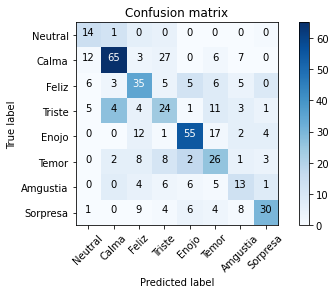

RandomForestClassifier(ccp_alpha=0.01616161616161616, criterion='entropy',
                       max_depth=19)

In [42]:
random_forest.fit(X_Dev_without_special_columns, y_dev)

show_summary(random_forest, X_test_without_special_columns, y_test, emotions)

Ada Boost:

In [43]:
%%time

shp2 = search_hyper_parameters(
    model       = AdaBoostClassifier(), 
    X           = actors_fold_input, 
    y           = y_dev, 
    cv          = cv_strategy_2,
    groups      = actors_fold_groups,
    params_grid = {
        'n_estimators' : np.arange(10, 20, 1),
        'learning_rate': np.arange(0, 1, 0.001)
    }
)

Fitting 12 folds for each of 50 candidates, totalling 600 fits


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    9.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:   22.9s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:   33.0s finished


CPU times: user 1.51 s, sys: 82.5 ms, total: 1.59 s
Wall time: 33.5 s


Con los mejores hiperparametros encontrados (entrenando con training y evaluando en validation) entrenamos en development y evaluamos en test:

In [44]:
ada_boost = AdaBoostClassifier()
ada_boost.set_params(**shp2.best_params_)
ada_boost

AdaBoostClassifier(learning_rate=0.6920000000000001, n_estimators=19)

In [45]:
models.append(ada_boost)

Accuracy: 39.5112 %

Classification Report:
              precision    recall  f1-score   support

     Neutral       0.39      0.34      0.37        38
       Calma       0.53      0.52      0.53        75
       Feliz       0.55      0.48      0.51        75
      Triste       0.37      0.21      0.27        75
       Enojo       0.33      0.68      0.44        75
       Temor       0.25      0.23      0.24        75
    Amgustia       0.35      0.21      0.26        39
    Sorpresa       0.48      0.36      0.41        39

    accuracy                           0.40       491
   macro avg       0.41      0.38      0.38       491
weighted avg       0.41      0.40      0.39       491



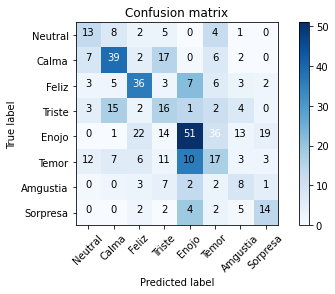

AdaBoostClassifier(learning_rate=0.6920000000000001, n_estimators=19)

In [46]:
ada_boost.fit(X_Dev_without_special_columns, y_dev)

show_summary(ada_boost, X_test_without_special_columns, y_test, emotions)

Gradient Boosting:

In [47]:
%%time

shp3 = search_hyper_parameters(
    model       = GradientBoostingClassifier(),  
    X           = actors_fold_input, 
    y           = y_dev, 
    cv          = cv_strategy_2,
    groups      = actors_fold_groups,
    params_grid = {
        'n_estimators' : np.arange(10, 20, 1),
        'learning_rate': np.arange(0, 1, 0.001)
    }
)

Fitting 12 folds for each of 50 candidates, totalling 600 fits


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:   14.4s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:  2.4min
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:  5.7min
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:  8.0min finished


CPU times: user 6.47 s, sys: 64.2 ms, total: 6.53 s
Wall time: 8min 6s


Con los mejores hiperparametros encontrados (entrenando con training y evaluando en validation) entrenamos en development y evaluamos en test:

In [48]:
gradient_boosting = GradientBoostingClassifier()
gradient_boosting.set_params(**shp3.best_params_)
gradient_boosting

GradientBoostingClassifier(learning_rate=0.167, n_estimators=18)

In [49]:
models.append(gradient_boosting)

Accuracy: 62.1181 %

Classification Report:
              precision    recall  f1-score   support

     Neutral       0.89      0.66      0.76        38
       Calma       0.70      0.76      0.73        75
       Feliz       0.58      0.60      0.59        75
      Triste       0.53      0.52      0.52        75
       Enojo       0.72      0.76      0.74        75
       Temor       0.57      0.52      0.54        75
    Amgustia       0.46      0.46      0.46        39
    Sorpresa       0.60      0.64      0.62        39

    accuracy                           0.62       491
   macro avg       0.63      0.62      0.62       491
weighted avg       0.62      0.62      0.62       491



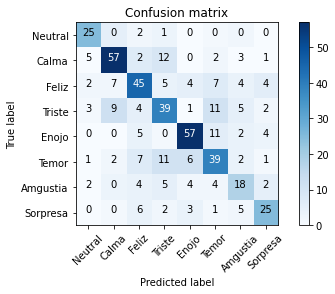

GradientBoostingClassifier(learning_rate=0.167, n_estimators=18)

In [50]:
gradient_boosting.fit(X_Dev_without_special_columns, y_dev)

show_summary(gradient_boosting, X_test_without_special_columns, y_test, emotions)

XGBoost:

In [51]:
%%time

shp4 = search_hyper_parameters(
    model       = XGBClassifier(),  
    X           = actors_fold_input, 
    y           = y_dev, 
    cv          = cv_strategy_2,
    groups      = actors_fold_groups,
    params_grid = {
        'classifier__n_estimators' : np.arange(10, 20, 1),
        'classifier__learning_rate': np.arange(0, 1, 0.001)
    }
)

Fitting 12 folds for each of 50 candidates, totalling 600 fits


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:  1.9min
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 22.5min
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed: 57.9min
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 84.1min finished


[00:23:38] WARNING: ../src/learner.cc:573: 
Parameters: { "classifier__learning_rate", "classifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:23:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 29.1 s, sys: 94.9 ms, total: 29.2 s
Wall time: 1h 24min 10s


In [52]:
xgboost = XGBClassifier()
xgboost.set_params(**shp4.best_params_)
xgboost

XGBClassifier(base_score=None, booster=None, classifier__learning_rate=0.639,
              classifier__n_estimators=11, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

In [53]:
models.append(xgboost)

[00:23:42] WARNING: ../src/learner.cc:573: 
Parameters: { "classifier__learning_rate", "classifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:23:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 72.0978 %

Classification Report:
              precision    recall  f1-score   support

     Neutral       0.70      0.79      0.74        38
       Calma       0.75      0.83      0.78        75
       Feliz       0.74      0.68      0.71        75
      Triste       0.69      0.60      0.64        75
       Enojo       0.79      0.87      0.83        75
   

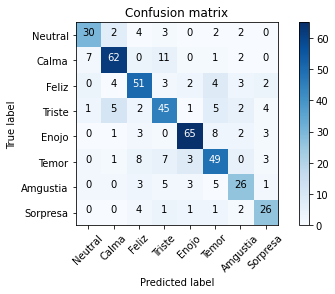

XGBClassifier(base_score=0.5, booster='gbtree', classifier__learning_rate=0.639,
              classifier__n_estimators=11, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [54]:
xgboost.fit(X_Dev_without_special_columns, y_dev)

show_summary(xgboost, X_test_without_special_columns, y_test, emotions)

Ahora seleccionamos el mejor modelo:

In [55]:
max_score, best_model = get_max_score_model(models, X_test_without_special_columns, y_test)

print('\n\n=> El mejor modelo es "{}" con un accuracy de {:.3f} %.\n\n'.format(type(best_model).__name__, max_score * 100))



=> El mejor modelo es "XGBClassifier" con un accuracy de 72.098 %.




Luego con el mejor modelo evaluar el conjunto de test para distintas polaciones como speechs vs songs, femeninas vs masculinas:

Accuracy: 72.0978 %

Classification Report:
              precision    recall  f1-score   support

     Neutral       0.70      0.79      0.74        38
       Calma       0.75      0.83      0.78        75
       Feliz       0.74      0.68      0.71        75
      Triste       0.69      0.60      0.64        75
       Enojo       0.79      0.87      0.83        75
       Temor       0.69      0.65      0.67        75
    Amgustia       0.60      0.67      0.63        39
    Sorpresa       0.74      0.67      0.70        39

    accuracy                           0.72       491
   macro avg       0.71      0.72      0.71       491
weighted avg       0.72      0.72      0.72       491



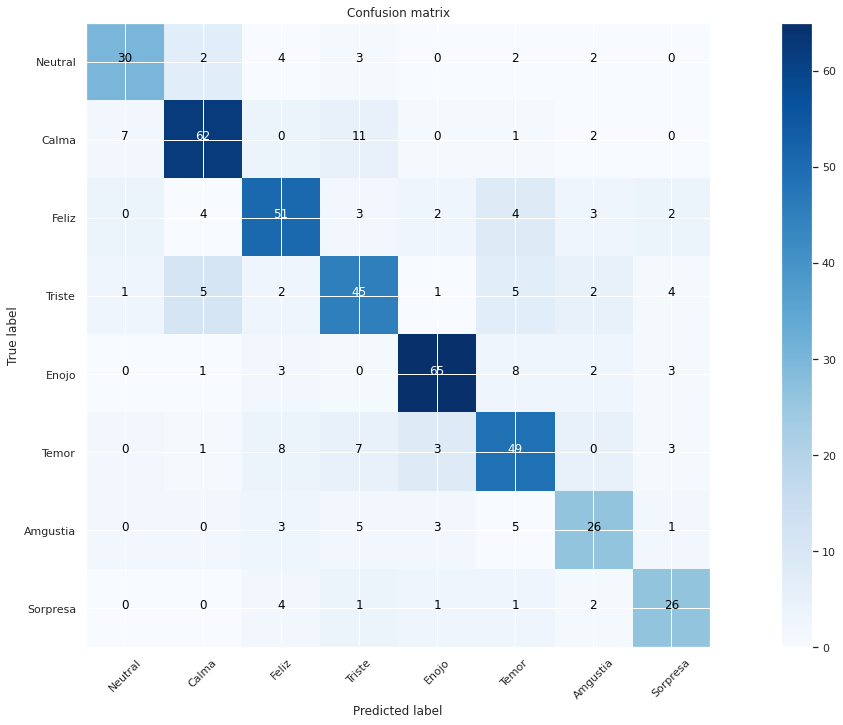

XGBClassifier(base_score=0.5, booster='gbtree', classifier__learning_rate=0.639,
              classifier__n_estimators=11, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [80]:
show_summary(best_model, X_test_without_special_columns, y_test, emotions)

In [62]:
man_actors   = [x for x in features['actor'].unique() if x % 2 == 0]
woman_actors = [x for x in features['actor'].unique() if x % 2 != 0]

In [63]:
def filter_set(X, y, column, values): return X[X[column].isin(values)], y[X[column].isin(values)]

speechs_features, speechs_y_true = filter_set(X_test_without_special_columns, y_test, 'vocal_channel', [0])
songs_features,   songs_y_true   = filter_set(X_test_without_special_columns, y_test, 'vocal_channel', [1])

man_features,     man_y_true     = filter_set(X_test, y_test, 'actor', man_actors)
woman_features,   woman_y_true   = filter_set(X_test, y_test, 'actor', woman_actors)

man_features   = exclude_columns(man_features,   special_columns)
woman_features = exclude_columns(woman_features, special_columns)

Audios Cantados vs Hablados:

Hablados

Accuracy: 87.1921 %

Classification Report:
              precision    recall  f1-score   support

           1       0.91      0.95      0.93        22
           2       0.88      0.90      0.89        39
           3       0.82      0.94      0.88        34
           4       0.84      0.82      0.83        33
           5       0.91      0.94      0.93        34
           6       0.88      0.73      0.80        41

    accuracy                           0.87       203
   macro avg       0.87      0.88      0.88       203
weighted avg       0.87      0.87      0.87       203



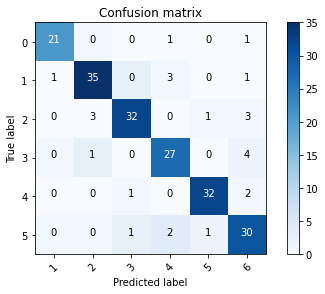

XGBClassifier(base_score=0.5, booster='gbtree', classifier__learning_rate=0.639,
              classifier__n_estimators=11, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [64]:
show_summary(best_model, speechs_features, speechs_y_true, emotions)

Cantados

Accuracy: 61.4583 %

Classification Report:
              precision    recall  f1-score   support

           1       0.45      0.56      0.50        16
           2       0.63      0.75      0.68        36
           3       0.63      0.46      0.54        41
           4       0.55      0.43      0.48        42
           5       0.70      0.80      0.75        41
           6       0.51      0.56      0.54        34
           7       0.60      0.67      0.63        39
           8       0.74      0.67      0.70        39

    accuracy                           0.61       288
   macro avg       0.60      0.61      0.60       288
weighted avg       0.62      0.61      0.61       288



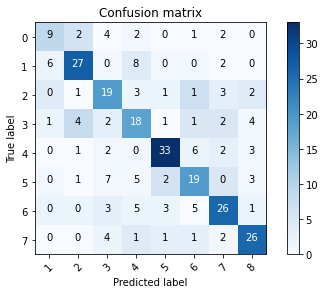

XGBClassifier(base_score=0.5, booster='gbtree', classifier__learning_rate=0.639,
              classifier__n_estimators=11, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [65]:
show_summary(best_model, songs_features, songs_y_true, emotions)

Feneninos

Accuracy: 73.7452 %

Classification Report:
              precision    recall  f1-score   support

           1       0.62      0.75      0.68        20
           2       0.76      0.86      0.81        36
           3       0.82      0.64      0.72        44
           4       0.76      0.65      0.70        40
           5       0.80      0.88      0.84        42
           6       0.81      0.71      0.75        41
           7       0.56      0.74      0.64        19
           8       0.58      0.65      0.61        17

    accuracy                           0.74       259
   macro avg       0.71      0.73      0.72       259
weighted avg       0.75      0.74      0.74       259



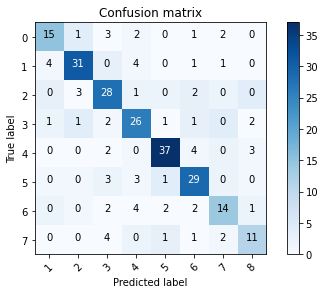

XGBClassifier(base_score=0.5, booster='gbtree', classifier__learning_rate=0.639,
              classifier__n_estimators=11, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [66]:
show_summary(best_model, woman_features, woman_y_true, emotions)

Masculinos

Accuracy: 70.2586 %

Classification Report:
              precision    recall  f1-score   support

           1       0.79      0.83      0.81        18
           2       0.74      0.79      0.77        39
           3       0.66      0.74      0.70        31
           4       0.61      0.54      0.58        35
           5       0.78      0.85      0.81        33
           6       0.57      0.59      0.58        34
           7       0.67      0.60      0.63        20
           8       0.94      0.68      0.79        22

    accuracy                           0.70       232
   macro avg       0.72      0.70      0.71       232
weighted avg       0.71      0.70      0.70       232



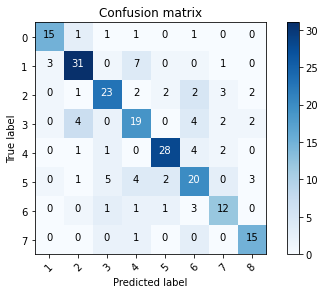

XGBClassifier(base_score=0.5, booster='gbtree', classifier__learning_rate=0.639,
              classifier__n_estimators=11, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [67]:
show_summary(best_model, man_features, man_y_true, emotions)

#### 4. Evaluar la robustez del mejor modelo ante la presencia de ruido en los audios. Realizar una curva que muestre cómo varía una métrica de desempeño para distintas relaciones señal a ruido. El ruido utilizado puede ser sintético (gaussiano por ejemplo), o ruido ambiental. Algunas fuentes de ruido ambiental son:

Comparemos un ejemplo sin ruido contra otro con cierto nivel de ruido:

In [69]:
example_path = X_test['file_path'].values[0]
play_audio(example_path)

Para agregar ruido al audio usamos la funcion **create_new_file_with_noise**. Esta funcion agrega ruido al audio usando la relacion senal ruido(SNR):

In [70]:
noise_example_path = create_new_file_with_noise(example_path, level = 10 ** -4)

print(noise_example_path)
play_audio(noise_example_path)

./speech/Actor_17/noisy/e424c8d6-d62f-11eb-9794-4551a21cd351-03-01-05-02-02-02-17.wav


Redefinimos la funcion que extrae los features de cada audio. Esta nueva funcion agregar ruido al audio antes de extraer sus features.

In [71]:
def feature_extraction_with_noise(file_path, noise_level):
    if noise_level > 0:
        file_path = create_new_file_with_noise(file_path, noise_level)
    return get_functional_feats(file_path)

Comparemos los features con y sin ruido:

In [72]:
feature_extraction_with_noise(noise_example_path, noise_level = 0.0005)

,file,start,end,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,./speech/Actor_17/noisy/noisy/e58068f2-d62f-11...,0 days,0 days 00:00:03.803812500,33.327438,0.074751,31.313637,32.994659,35.872791,4.559155,33.659878,...,0.013122,0.000899,0.438596,2.110818,1.336898,0.192,0.084711,0.445,0.486886,-24.221197


In [73]:
feature_extraction_with_noise(noise_example_path, noise_level = 0)

,file,start,end,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,./speech/Actor_17/noisy/e424c8d6-d62f-11eb-979...,0 days,0 days 00:00:03.803812500,32.420189,0.108083,30.839293,32.529995,35.59737,4.758078,99.78582,...,0.023321,0.003122,0.142292,1.846966,1.336898,0.232,0.09152,0.411667,0.474778,-25.225071


A continuacion vamos a probar cada uno de los modelos del punto 3 evaluandolos en el conjunto de test e inyectando distintos niveles de ruido. De esta manera podemos compara como se comporta cada modelo ante la presencia de ruido. La funcion **plot_noise_vs_accuracy_curve** entrena el modelo para distintos niveles de ruido y grafica cada nivel de ruido vs accuracy.

In [74]:
def generate_noisy_features(example_paths, noise_level):
    examples = Dataset().search_by_paths(
        example_paths, 
        feature_extract_fn = lambda file_path: feature_extraction_with_noise(file_path, noise_level)
    )
    
    X, y = features_target(examples)
    X = exclude_columns(X, special_columns)

    return X, y

def noise_vs_accuracy_metrics(models, example_paths, y_test, noise_levels):
    accuracy = {type(m).__name__:[] for m in models }
    
    for noise_level in noise_levels:
        X_noise, _ = generate_noisy_features(example_paths, noise_level)
        y_true     = y_test.iloc[X_noise.index.values, :]

        for i, model in enumerate(models):
            acc = model.score(X_noise, y_true)
            accuracy[type(model).__name__].append(acc)
            print('Model: {}, SNR: {}, Accuracy: {:.2f} %'.format(type(model).__name__, noise_level, acc * 100))

    return noise_levels, accuracy

In [75]:
noise_levels = [10 ** -v for v in range(300, 0, -25)] + [10 ** -v for v in range(9, 0, -1)] + list(range(1, 20, 5))
noise_levels

[1e-300,
 1e-275,
 1e-250,
 1e-225,
 1e-200,
 1e-175,
 1e-150,
 1e-125,
 1e-100,
 1e-75,
 1e-50,
 1e-25,
 1e-09,
 1e-08,
 1e-07,
 1e-06,
 1e-05,
 0.0001,
 0.001,
 0.01,
 0.1,
 1,
 6,
 11,
 16]

In [76]:
test_example_paths = X_test['file_path'].unique()

Realizamos la grafica SNR vs Accuracy usando el conjunto de test:

In [ ]:
noise_levels, accuracy = noise_vs_accuracy_metrics(
    models,
    test_example_paths, 
    y_test, 
    noise_levels
)

In [78]:
sns.set_style("white")
sns.despine()
sns.set(rc={'figure.figsize':(20, 10)})

def plot_metrics(noise_levels, accuracy):
    for model_name in accuracy:
        sns.lineplot(noise_levels, accuracy[model_name], label=model_name)
    plt.xlabel('SNR')
    plt.ylabel('Accuracy')
    plt.show()

<Figure size 432x288 with 0 Axes>

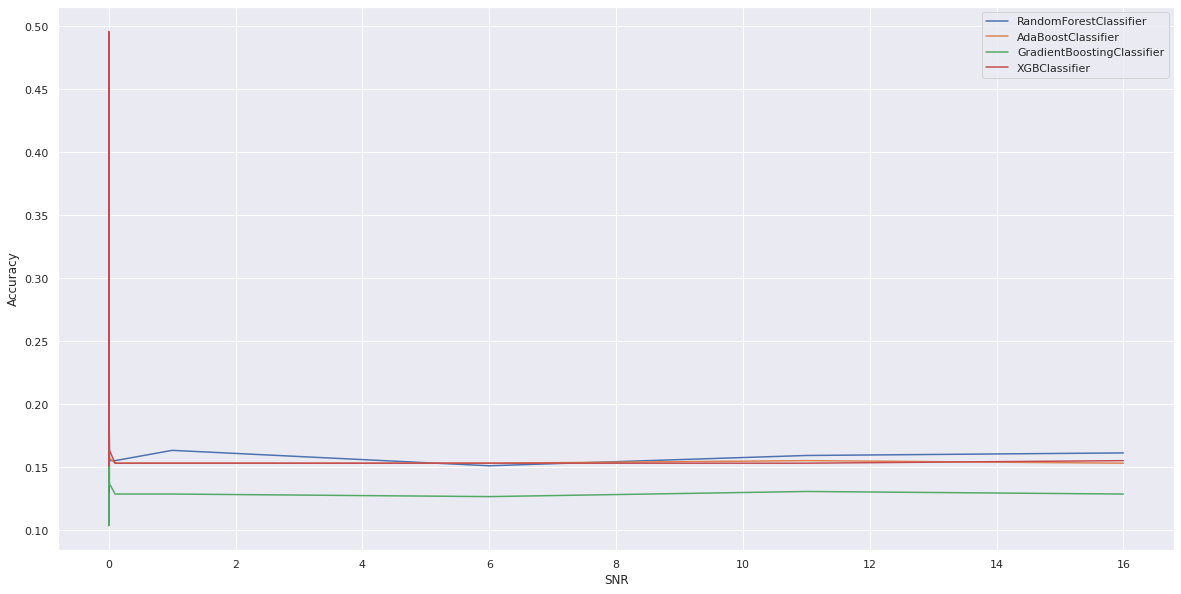

In [79]:
plot_metrics(noise_levels, accuracy)